In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = open('names.txt', 'r').read().splitlines()


In [10]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [11]:
block_size = 3

In [12]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [13]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [14]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)

    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

      0/ 200000: 3.3142
  10000/ 200000: 2.1941
  20000/ 200000: 2.3444
  30000/ 200000: 2.4160
  40000/ 200000: 1.9912
  50000/ 200000: 2.2980
  60000/ 200000: 2.5257
  70000/ 200000: 2.0705
  80000/ 200000: 2.3112
  90000/ 200000: 2.0662
 100000/ 200000: 1.9930
 110000/ 200000: 2.3182
 120000/ 200000: 1.9124
 130000/ 200000: 2.4502
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0460
 170000/ 200000: 1.8835
 180000/ 200000: 1.9988
 190000/ 200000: 1.8873


In [15]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [16]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / (bnstd_running + 1e-5) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 2.0781
val loss: 2.1128


In [17]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(1, -1)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

dexz.
kaddhk.
sarvezkayd.
mel.
martna.
vra.
fusska.
dakshlvyn.
bravsh.
votti.
mari.
dlynn.
kenzed.
jena.
makesldlynn.
bvyctylynn.
prdwynn.
brth.
las.
damir.


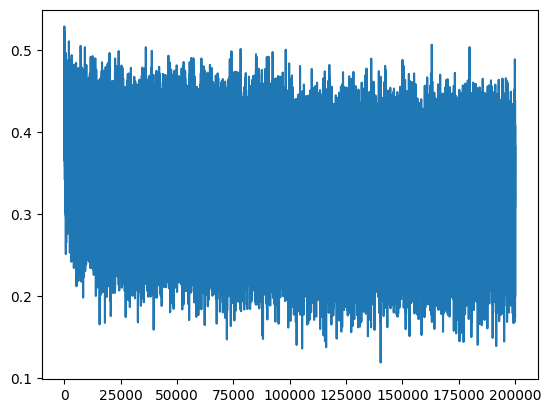

In [18]:
plt.plot(lossi)

-0.00288582150824368 0.999890923500061
-0.0024989512749016285 1.020529866218567


(array([1.0000e+00, 1.0000e+00, 1.0000e+00, 7.0000e+00, 1.6000e+01,
        3.2000e+01, 1.0300e+02, 2.2000e+02, 5.0400e+02, 1.1410e+03,
        2.3420e+03, 4.8020e+03, 9.1050e+03, 1.5199e+04, 2.3118e+04,
        3.0004e+04, 3.2286e+04, 2.9002e+04, 2.1820e+04, 1.3938e+04,
        8.1320e+03, 4.2970e+03, 2.1860e+03, 9.7200e+02, 4.5800e+02,
        1.8800e+02, 8.2000e+01, 3.2000e+01, 7.0000e+00, 4.0000e+00]),
 array([-6.38201332, -5.99336799, -5.60472266, -5.21607733, -4.827432  ,
        -4.43878667, -4.05014133, -3.661496  , -3.27285067, -2.88420534,
        -2.49556001, -2.10691468, -1.71826935, -1.32962402, -0.94097869,
        -0.55233335, -0.16368802,  0.22495731,  0.61360264,  1.00224797,
         1.3908933 ,  1.77953863,  2.16818396,  2.55682929,  2.94547462,
         3.33411996,  3.72276529,  4.11141062,  4.50005595,  4.88870128,
         5.27734661]),
 <BarContainer object of 30 artists>)

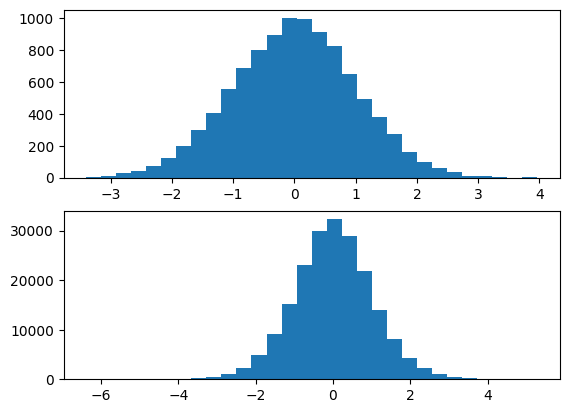

In [19]:
x = torch.randn((1000, 10))
w = torch.randn((10, 200)) / 10**0.5
y = x @ w
print(f'{x.mean()} {x.std()}')
print(f'{y.mean()} {y.std()}')
plt.subplot(2, 1, 1)
plt.hist(x.view(-1).tolist(), bins=30)
plt.subplot(2, 1, 2)
plt.hist(y.view(-1).tolist(), bins=30)